In [8]:
import os
import pandas as pd
from paths import DIR_DATA, PATH_DATA_TEST, PATH_DATA_TRAIN
import markov
from markov.settings import DEF_SMOOTHING_WEIGHT, DEF_VOCAB_SIZE

DIR_RESULTS = os.path.join(DIR_DATA, 'results')
DIR_FIGURES = os.path.join(DIR_DATA, 'figures')

In [2]:
df_train = pd.read_csv(PATH_DATA_TRAIN)

In [3]:
import regex as re

def get_crossval_sets(df: pd.DataFrame, num_sets: int):

    df_shuffled: pd.DataFrame = df.sample(frac=1, random_state=0)
    len_chunk = len(df) / num_sets

    sets = {}
    sets['train'] = [None] * num_sets
    sets['val'] = [None] * num_sets

    for i in range(num_sets):
        start = round(i * len_chunk)
        end = round((i + 1) * len_chunk)
        sets['val'][i] = df_shuffled.iloc[start:end,:]
        sets['train'][i] = df_shuffled[~df_shuffled.index.isin(sets['val'][i].index)]

    return sets

def get_wordlist(text: str) -> list[str]:
    cleaned = text.lower()
    cleaned = re.sub(r'https?:\/\/.*[\r\n]*|[^\w\s]', ' ', cleaned)
    return cleaned.split()

def get_instances(df: pd.DataFrame, target: int, mapping = lambda x: x):
    return list(map(mapping, (df.loc[df['target'] == target])['text'].to_list()))

def get_features_and_labels(df: pd.DataFrame, mapping = lambda x: x):
    features = list(map(mapping, df['text'].to_list()))
    labels = df['target'].to_list()
    return (features, labels)

In [36]:
import time
import matplotlib.pyplot as plt

def save_cm(cm: markov.ConfusionMatrix, path: str):
    disp = cm.get_display(display_labels=['Disaster', 'No Disaster'])
    disp.ax_.set_xlabel('Predicted')
    disp.ax_.set_ylabel('Actual')   
    disp.ax_.set_title(f'F1 Score: {cm.get_f1():.2f}')
    disp.figure_.savefig(path ,pad_inches=0.2, bbox_inches='tight', dpi=300)

def test_orders(df: pd.DataFrame, num_sets: int = 5, mapping = lambda x: x, order_min: int = 0, order_max: int = 15, 
                print_results: bool = False, vocab_size: int = DEF_VOCAB_SIZE, smoothing_weight: float = DEF_SMOOTHING_WEIGHT, file = None, image_prefix = ''):

    order_max += 1
    sets = get_crossval_sets(df, num_sets)
    f1_scores = [0] * (order_max - order_min)
    cms = [None] * (order_max - order_min)

    if file:
        file.write(f'Order,Num Instances,Num Splits,Training Time (Total),Training Time (Avg),Validation Time (Total),Validation Time (Avg),TP (Total),TP (Avg),FP (Total),FP (Avg),TN (Total),TN (Avg),FN (Total), FN (Avg),Precision,Recall,F1\n')

    for order in range(order_min, order_max):
        total = markov.ConfusionMatrix()
        time_training = 0.0
        time_validation = 0.0

        for i in range(num_sets):
            (features, labels) = get_features_and_labels(sets['train'][i], mapping)
            start = time.time()
            classifier = markov.Classifier(order, features, labels, vocab_size=vocab_size, smoothing_weight=smoothing_weight)
            
            time_training += time.time() - start
            (features, labels) = get_features_and_labels(sets['val'][i], mapping)
            start = time.time()
            cm = classifier.eval(features, labels)
            
            time_validation += time.time() - start
            total = total.add(cm)

        average = total.div(num_sets)
        cms[order - order_min] = average

        if print_results:
            print(f'Order {order} results: ', end='')
            print(average)
            print(f'Training: [Tot.: {time_training:5.3f}s, Avg.: {time_training / num_sets:5.3f}s], Validation: [Tot.: {time_validation:5.3f}s, Avg.: {time_validation / num_sets:5.3f}s]')

        if file:
            file.write(f'{order},{len(df)},{num_sets},{time_training},{time_training / num_sets},{time_validation},{time_validation / num_sets},{total.tp},{average.tp},{total.fp},{average.fp},{total.tn},{average.tn},{total.fn},{average.fn},{total.get_precision()},{total.get_recall()},{total.get_f1()}\n')

        if image_prefix:
            save_cm(total, image_prefix + '_' + str(order) + '_total.png')
            save_cm(average, image_prefix + '_' + str(order) + '_avg.png')

    f1_scores = map(markov.ConfusionMatrix.get_f1, cms)
    max_f1_index = max((v, i) for i, v in enumerate(f1_scores))[1]
    return (max_f1_index, cms[max_f1_index])

Order 0 results: Total: 1522.6, TP: 442.8, TN: 546.6, FP: 321.8, FN: 211.4, Prc: 0.579, Rec. 0.677, F1: 0.624
Training: [Tot.: 2.851s, Avg.: 0.570s], Validation: [Tot.: 2.457s, Avg.: 0.491s]


KeyboardInterrupt: 

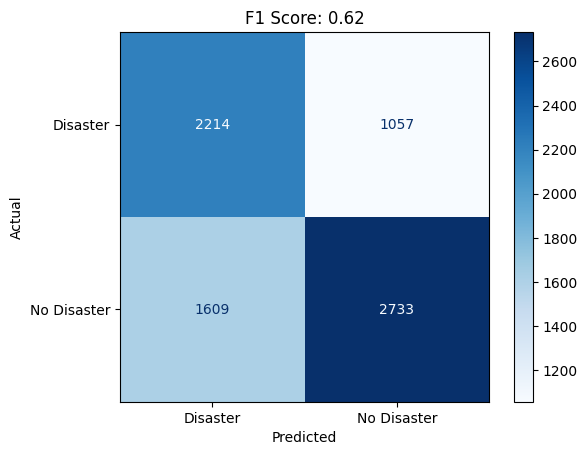

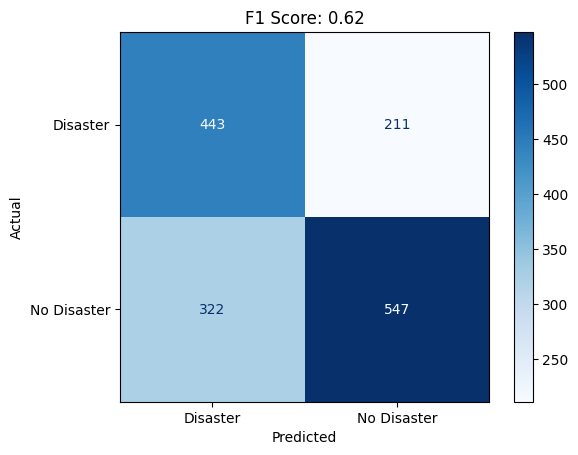

In [38]:
NUM_SETS = 5

with open(os.path.join(DIR_RESULTS, 'markov_char.csv'), 'w') as f:
    print(f'Best order character based: {test_orders(df_train, NUM_SETS, print_results=True, file=f, image_prefix=os.path.join(DIR_FIGURES, 'markov_char'))}')
    
with open(os.path.join(DIR_RESULTS, 'markov_word.csv'), 'w') as f:
    print(f'Best order word based: {test_orders(df_train, NUM_SETS, get_wordlist, vocab_size=40000, print_results=True, file=f, image_prefix=os.path.join(DIR_FIGURES, 'markov_word'))}')